## **We will analyse the various clusters in the internshala job listing**

### **Import neccesary libraries**

In [32]:
from gensim.models import Word2Vec, Doc2Vec
import nltk 
import numpy as np 
from nltk.corpus import stopwords # Filter out stopwords, such as 'the', 'or', 'and'
import pandas as pd
from sklearn.cluster import KMeans 
from sklearn import cluster
from sklearn.neighbors import KDTree
from sklearn import metrics 
from sklearn.decomposition import PCA 
from scipy.cluster import hierarchy 
from sklearn.cluster import AffinityPropagation
import re
from wordcloud import WordCloud, ImageColorGenerator
from itertools import cycle;

### **Download NLTK stop words list**

In [33]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

### **Upgrade packages if needed**

In [ ]:
!pip install gensim --upgrade
!pip install nltk  --upgrade
!pip install numpy --upgrade
!pip install scikit-learn --upgrade
!pip install scipy --upgrade
!pip install matplotlib --upgrade

### **Upload dataset to Google Collab**

In [3]:
from google.colab import files
uploaded = files.upload()

Saving Job_Scrapping_Internshala_.xlsx to Job_Scrapping_Internshala_.xlsx


### **Import the dataset**

In [34]:
import io
df_jobs = pd.read_excel(io.BytesIO(uploaded['Job_Scrapping_Internshala_.xlsx']))
# Dataset is now stored in a Pandas Dataframe

In [35]:
df_jobs.head()

,Unnamed: 0,job_title,company_name,location,salary,description
0,1,Machine Learning Model Building (For OCR Tool),IIT Bombay,Mumbai,3000-5000 /month,Selected intern's day-to-day responsibilities ...
1,2,Deep Learning,IIT Bombay,Work From Home,2000-4000 /month,Selected intern's day-to-day responsibilities ...
2,3,Machine Learning,"Getboarded Technologies, LDA",Work From Home,2000 /month,Selected intern's day-to-day responsibilities ...
3,4,Machine Learning,TorqueVision Labs LLC,Indore,5000 /month,Selected intern's day-to-day responsibilities ...
4,5,Communication,India Sanitation Coalition,Delhi,10000 /month,Selected intern's day-to-day responsibilities ...


### **Perform some pre-processing steps on the data**

In [36]:
# pre process the test.
stop_words = set(stopwords.words("english"))
def normalize_text(text):
    text = re.sub("Selected intern's day-to-day responsibilities include:", "", text)    # remove common string from all jobs 
    regex = r"(\d(?:\.|\))\s+)|([a-z]\)\s+)|(•\s+)|([A-Z]\.\s+)|((?:[IVX]|[ivx])+(?:\.|\))\s+)"
    text = text.strip().replace("\n","").lower()     # convert to lowercase
    text = re.sub(regex, "", text)                   # remove all bullet points
    words = text.split()                             # Filter out any stop words
    text_without_stops = ""
    for word in words:
      if not word in stop_words:
        text_without_stops = text_without_stops + word + " "
    return text_without_stops

In [37]:
df_jobs['description_'] = df_jobs.apply(lambda row: normalize_text(row["description"]),axis=1)

### **Tokenize the job descriptions**

In [38]:
# build word2vec model
wpt = nltk.WordPunctTokenizer()
tokenized_corpus = [wpt.tokenize(df_jobs['description_'][ind]) for ind in df_jobs.index]

### **Build the Worde2Vec model to vectorize the job descriptions**

In [39]:
# Set values for various parameters
feature_size = 10    # Word vector dimensionality  
window_context = 10          # Context window size                                                                                    
min_word_count = 1   # Minimum word count                        
sample = 1e-3   # Downsample setting for frequent words

w2v_model = Word2Vec(tokenized_corpus, size=feature_size, 
                              window=window_context, min_count = min_word_count,
                              sample=sample, iter=100)

#### **Utility methods to find the vectors of the job description**

##### We will find the word vectors of all the words in the job description and average them out to find the vector for the job description

In [40]:
def average_word_vectors(words, model, vocabulary, num_features):
    
    feature_vector = np.zeros((num_features,),dtype="float64")
    nwords = 0.
    
    for word in words:
        if word in vocabulary: 
            nwords = nwords + 1.
            feature_vector = np.add(feature_vector, model[word])
    
    if nwords:
        feature_vector = np.divide(feature_vector, nwords)
        
    return feature_vector
    
   
def averaged_word_vectorizer(corpus, model, num_features):
    vocabulary = set(model.wv.index2word)
    features = [average_word_vectors(tokenized_sentence, model, vocabulary, num_features)
                    for tokenized_sentence in corpus]
    return np.array(features)

In [ ]:
# get document level embeddings
w2v_feature_array = averaged_word_vectorizer(corpus=tokenized_corpus, model=w2v_model,
                                             num_features=feature_size)
pd.DataFrame(w2v_feature_array)

**Clustering using AffinityProagation**

In [42]:
ap = AffinityPropagation( )
ap.fit(w2v_feature_array)
cluster_labels = ap.labels_
cluster_labels = pd.DataFrame(cluster_labels, columns=['ClusterLabel_Aff_Prop'])
df_jobs_clustered = pd.concat([df_jobs, cluster_labels], axis=1)

/usr/local/lib/python3.6/dist-packages/sklearn/cluster/_affinity_propagation.py:152: FutureWarning: 'random_state' has been introduced in 0.23. It will be set to None starting from 0.25 which means that results will differ at every function call. Set 'random_state' to None to silence this warning, or to 0 to keep the behavior of versions <0.23.
  FutureWarning)


In [43]:
df_jobs_clustered.head()

,Unnamed: 0,job_title,company_name,location,salary,description,description_,ClusterLabel_Aff_Prop
0,1,Machine Learning Model Building (For OCR Tool),IIT Bombay,Mumbai,3000-5000 /month,Selected intern's day-to-day responsibilities ...,"work data cleaning, pre-processing, image coll...",0
1,2,Deep Learning,IIT Bombay,Work From Home,2000-4000 /month,Selected intern's day-to-day responsibilities ...,conducting research implementing machine learn...,16
2,3,Machine Learning,"Getboarded Technologies, LDA",Work From Home,2000 /month,Selected intern's day-to-day responsibilities ...,"working code compliance python, numpy, tensorf...",7
3,4,Machine Learning,TorqueVision Labs LLC,Indore,5000 /month,Selected intern's day-to-day responsibilities ...,"working computer vision, deep learning, machin...",2
4,5,Communication,India Sanitation Coalition,Delhi,10000 /month,Selected intern's day-to-day responsibilities ...,support isc secretariat conducting execution a...,18


**As can be seen, the "AffinityPropagation" algorithm has found 17 clusters automatically. If this number seems high, we can adjust the hyperparamter "preferences" in the model**

**Clustering using Kmeans**

#### **Lets find the numbers of clusters using Kmeans**

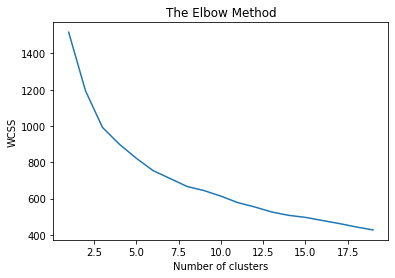

In [44]:
import matplotlib.pyplot as plt
wcss = [] 

for i in range(1, 20): 
  kmeans = KMeans(n_clusters=i, init = 'k-means++', random_state = 42 ) 
  kmeans.fit(w2v_feature_array) 
  wcss.append(kmeans.inertia_) 

plt.plot(range( 1,20), wcss) 
plt.title( 'The Elbow Method' ) 
plt.xlabel('Number of clusters') 
plt.ylabel('WCSS') 
plt.show() 

**There no clear elbow formed which specify the cluster number. Lets go ahead with "17" which was predicted by the AffinityPropagation algorithm.**

In [45]:
kmeans_clustering = KMeans(n_clusters = 8, init='k-means++');
idx = kmeans_clustering.fit_predict(w2v_feature_array)

In [46]:
cluster_labels_kmeans = pd.DataFrame(idx, columns=['ClusterLabel_kmeans'])
df_jobs_clustered_kmeans = pd.concat([df_jobs_clustered, cluster_labels_kmeans], axis=1)

In [47]:
df_jobs_clustered_kmeans.head()

,Unnamed: 0,job_title,company_name,location,salary,description,description_,ClusterLabel_Aff_Prop,ClusterLabel_kmeans
0,1,Machine Learning Model Building (For OCR Tool),IIT Bombay,Mumbai,3000-5000 /month,Selected intern's day-to-day responsibilities ...,"work data cleaning, pre-processing, image coll...",0,0
1,2,Deep Learning,IIT Bombay,Work From Home,2000-4000 /month,Selected intern's day-to-day responsibilities ...,conducting research implementing machine learn...,16,7
2,3,Machine Learning,"Getboarded Technologies, LDA",Work From Home,2000 /month,Selected intern's day-to-day responsibilities ...,"working code compliance python, numpy, tensorf...",7,5
3,4,Machine Learning,TorqueVision Labs LLC,Indore,5000 /month,Selected intern's day-to-day responsibilities ...,"working computer vision, deep learning, machin...",2,1
4,5,Communication,India Sanitation Coalition,Delhi,10000 /month,Selected intern's day-to-day responsibilities ...,support isc secretariat conducting execution a...,18,3


### **Wordcloud for each cluster**

In [24]:
centers = kmeans_clustering.cluster_centers_
clusters = idx
centroid_map = dict(zip(w2v_model.wv.index2word, clusters));

#### **Get top 20 words in each cluster (20 words closest to the centroid)**

In [106]:
def get_top_tech_terms(index2word, k, centers, wordvecs):
    tree = KDTree(wordvecs);

    #Closest points for each Cluster center is used to query the closest 20 points to it.
    closest_points = [tree.query(np.reshape(x, (1, -1)), k=k) for x in centers];

    closest_words_idxs = [x[1] for x in closest_points];

    str_of_tech_terms = """architecture model building rnn neural network aws artificial intelligence cnn R Python Java C++ 
     Ruby Perl Matlab JavaScript supervised unsupervised deploy nlp clustering chatbot dialogflow translation stacking
     Scala Analytics Hadoop Spark Visualization Deep Learning Computer Vision NLP MongoDB SQL NoSQL Cassandra Tableau SAS 
     D3 Sagemaker Azure Google Cloud natural language processing machine"""

    tokenized_tech_terms = wpt.tokenize(normalize_text(str_of_tech_terms))

    #Word Index is queried for each position in the above array, and added to a Dictionary.
    closest_words = {};
    for i in range(0, len(closest_words_idxs)):
        closest_words['Cluster #' + str(i).zfill(2)] = [index2word[j] for j in closest_words_idxs[i][0] if index2word[j] in tokenized_tech_terms]
    #A DataFrame is generated from the dictionary.
    #df = pd.DataFrame(closest_words);
    #df.index = df.index+1

    return closest_words;

In [30]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [107]:
closest_words = get_top_tech_terms(w2v_model.wv.index2word, 160, centers, w2v_feature_array);

In [108]:
def display_cloud(cluster_num, cmap):
  wc = WordCloud(background_color="black", max_words=2000, max_font_size=80, colormap=cmap);
  wordcloud = wc.generate(' '.join([word for word in closest_words['Cluster #' + str(cluster_num).zfill(2)]]))
  plt.figure()
  plt.imshow(wordcloud)
  plt.axis("off")
  #plt.savefig('cluster_' + str(cluster_num), bbox_inches='tight')

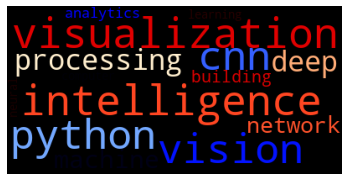

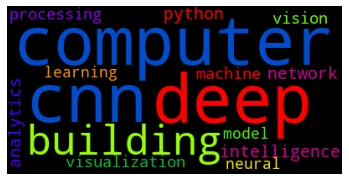

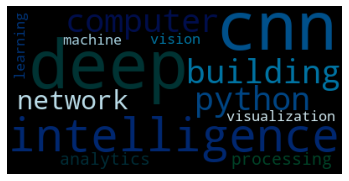

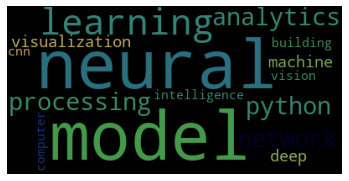

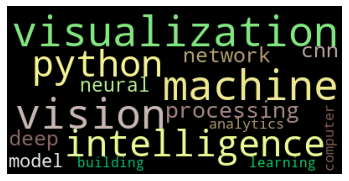

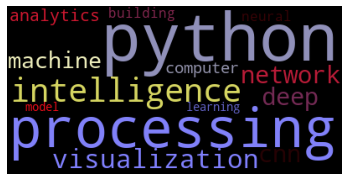

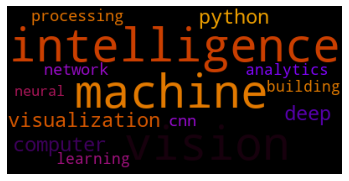

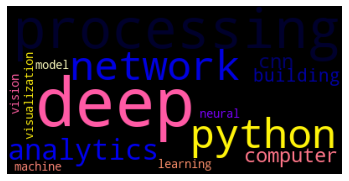

In [109]:
cmaps = cycle([
            'flag', 'prism', 'ocean', 'gist_earth', 'terrain', 'gist_stern',
            'gnuplot', 'gnuplot2', 'CMRmap', 'cubehelix', 'brg', 'hsv',
            'gist_rainbow', 'rainbow', 'jet', 'nipy_spectral', 'gist_ncar'])
for i in range(8):
    col = next(cmaps);
    display_cloud(i, col)

### **Find average stipend of the clusters**

#### **Feature engineer "Stipend"**

The "salary" column is having below mentioned values which are improper.

*   25000 /month
*   8000-10000 /month
*   Unpaid
*   2000 /month + Incentives
*   10000-15000 lump sum
*   2000 + Incentives

We need to clean this feature and convert it to float.

We will exclude the incentives and the lump sum concepts and consider the given salaries as stipend's per month.

Lets also strip unwanted texts from the values















In [110]:
df_jobs_clustered_kmeans['salary'] = df_jobs_clustered_kmeans['salary'].str.replace(' /month', '')
df_jobs_clustered_kmeans['salary'] = df_jobs_clustered_kmeans['salary'].str.replace(' /month + Incentives', '')
df_jobs_clustered_kmeans['salary'] = df_jobs_clustered_kmeans['salary'].str.replace('Incentives', '')
df_jobs_clustered_kmeans['salary'] = df_jobs_clustered_kmeans['salary'].str.replace('+', '')
df_jobs_clustered_kmeans['salary'] = df_jobs_clustered_kmeans['salary'].str.replace(' lump sum', '')
df_jobs_clustered_kmeans['salary'] = df_jobs_clustered_kmeans['salary'].str.replace('Unpaid', '0') 

Some salaries are specified as a range. Lets average out this range to get a single float stipend value

In [111]:
def clean_salary_cal_average(x):
  print(x)
  if isinstance(x, str):
    if "-" in x:
      print(x)
      num1 = x.split('-')[0] 
      num2 = x.split('-')[1]
      x = ((float(num1) + float(num2))/2)
  return x

In [ ]:
# creating of a new feature "stipend" which is the average value in case of a range.
df_jobs_clustered_kmeans['stipend'] = df_jobs_clustered_kmeans['salary'].apply(clean_salary_cal_average).astype('float')

In [113]:
# replace rows having stipend as 0 with mean
df_jobs_clustered_kmeans['stipend'] = df_jobs_clustered_kmeans['stipend'].replace(0, df_jobs_clustered_kmeans['stipend'].mean())

In [114]:
df_jobs_clustered_kmeans.head()

,Unnamed: 0,job_title,company_name,location,salary,description,description_,ClusterLabel_Aff_Prop,ClusterLabel_kmeans,stipend
0,1,Machine Learning Model Building (For OCR Tool),IIT Bombay,Mumbai,3000-5000,Selected intern's day-to-day responsibilities ...,"work data cleaning, pre-processing, image coll...",0,0,4000.0
1,2,Deep Learning,IIT Bombay,Work From Home,2000-4000,Selected intern's day-to-day responsibilities ...,conducting research implementing machine learn...,16,7,3000.0
2,3,Machine Learning,"Getboarded Technologies, LDA",Work From Home,2000,Selected intern's day-to-day responsibilities ...,"working code compliance python, numpy, tensorf...",7,5,2000.0
3,4,Machine Learning,TorqueVision Labs LLC,Indore,5000,Selected intern's day-to-day responsibilities ...,"working computer vision, deep learning, machin...",2,1,5000.0
4,5,Communication,India Sanitation Coalition,Delhi,10000,Selected intern's day-to-day responsibilities ...,support isc secretariat conducting execution a...,18,3,10000.0


**The average of stipend of all clusters is mentioned below**

In [115]:
df_jobs_clustered_kmeans.groupby(['ClusterLabel_kmeans'], as_index=False)['stipend'].mean()

,ClusterLabel_kmeans,stipend
0,0,7691.666667
1,1,9124.131697
2,2,6583.333333
3,3,7409.064120
4,4,8285.870176
5,5,8404.785714
6,6,9540.058102
7,7,5111.166667


In [ ]:
df_jobs_clustered_kmeans.to_csv("job_clustering.csv", encoding="utf-8")